# Import Library

In [ ]:
pip install yfinance


In [1]:
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
import joblib


# Load data

In [2]:
def get_nzdusd_data(start_date='2015-01-01', end_date=None, csv_path='nzdusd_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data NZD/USD dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('NZDUSD=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_nzdusd_data(end_date=None)  # end_date=None untuk hari ini


Mengunduh data NZD/USD dari Yahoo Finance: 2015-01-01 sampai 2025-06-09
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data disimpan ke nzdusd_data.csv


# EDA

## Cek missing value & duplikat

In [4]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [5]:
data.duplicated().sum()

np.int64(0)

## Meneliti 5 data terakhir

In [6]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-06-02,0.597311,0.603971,0.597600,0.597600,0
2025-06-03,0.604789,0.605521,0.598982,0.604891,0
2025-06-04,0.600611,0.603460,0.599351,0.600601,0
2025-06-05,0.602740,0.608091,0.602689,0.602689,0
2025-06-06,0.604230,0.605300,0.600749,0.604252,0


## Meneliti dimensi dataset

In [7]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2716, 5)


## Meneliti nilai

In [8]:
data.describe()

,Close,High,Low,Open,Volume
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.0
mean,0.663723,0.666680,0.660872,0.663711,0.0
std,0.048713,0.048764,0.048647,0.048704,0.0
min,0.551849,0.557230,0.547861,0.551520,0.0
25%,0.623345,0.626123,0.620207,0.623345,0.0
50%,0.666716,0.669591,0.663964,0.666700,0.0
75%,0.702630,0.704978,0.699744,0.702452,0.0
max,0.784683,0.788892,0.780092,0.784621,0.0


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance
- Volume akan dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'NZD/USD Closing Price'}, xlabel='Date'>

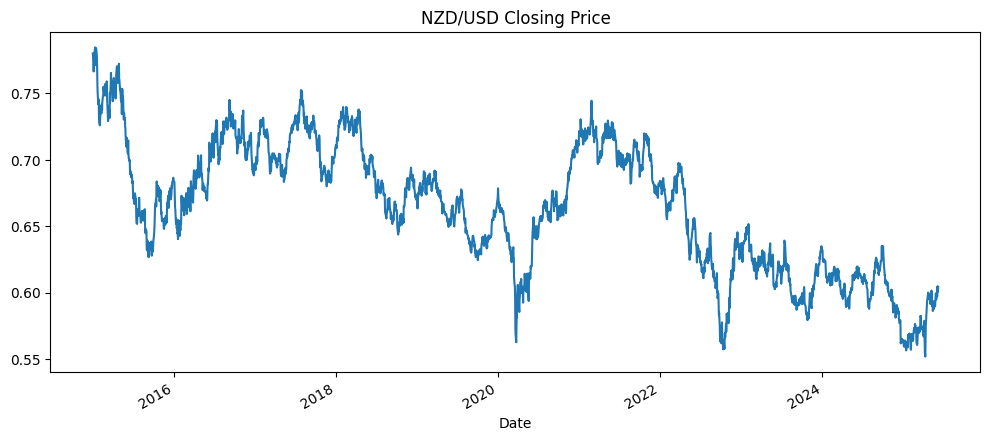

In [9]:
data['Close'].plot(figsize=(12, 5), title='NZD/USD Closing Price')

## Seasonality & Trend

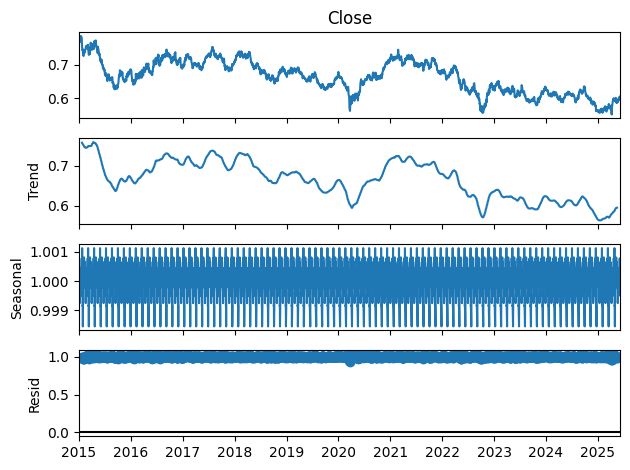

In [10]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
result.plot();

### Insight :     
- NZD/USD memiliki fluktuasi tren jangka panjang
- Fluktuasi seasonal cukup kecil dalam skala.
- Setelah 2021, terjadi penurunan tren yang cukup tajam hingga 2023. Kemungkinan besar karena efek pandemi corona.
- Terdapat fase tren naik dan turun yang panjang, cocok untuk digunakan dalam strategi long-term trading atau hedging.

## Boxplot

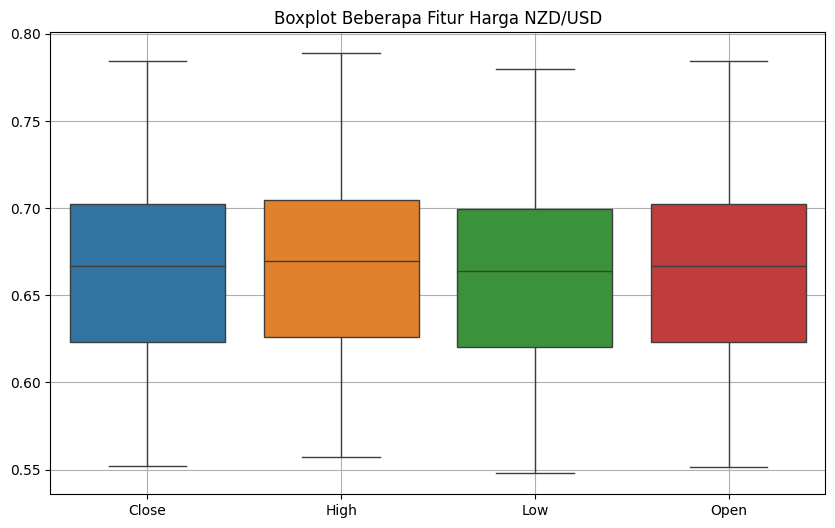

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga NZD/USD")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata dan bersih

# Data Preprocessing

In [12]:
# 1. Memastikan index dataframe adalah date
print(data.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)


In [13]:
# 2. Menghapus kolom volume
data.drop(columns=['Volume'], inplace=True)

# 3. Hitung perubahan harga harian (Price Change)
data['Price_Change'] = data['Close'].diff().fillna(0)

# 4. Klasifikasi perubahan harga (Price Range Class)
def classify_price_range(change):
    if change <= -0.01:
        return 'turunjauh'
    elif change <= -0.001:
        return 'turundekat'
    elif change > 0.01:
        return 'naikjauh'
    elif change > 0.001:
        return 'naikdekat'
    else:
        return 'stabil'

# 5. Klasifikasi range high-low harian (Volatilitas)
def classify_high_low_range(row):
    hl_range = row['High'] - row['Low']
    if hl_range > 0.01:
        return 'rangebesar'
    elif hl_range > 0.001:
        return 'rangesedang'
    elif hl_range > 0.0001:
        return 'rangekecil'
    else:
        return 'rangetipis'

data['Price_Range_Class'] = data['Price_Change'].apply(classify_price_range)
data['High_Low_Range_Class'] = data.apply(classify_high_low_range, axis=1)

# 6. Hitung RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# 7. Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# 8. Hitung MACD
def compute_macd(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_macd(data['Close'])

# 9. Drop NA rows (karena MA dan RSI awal akan kosong)
data.dropna(inplace=True)

In [14]:
# Meneliti 5 data terakhir setelah menambahkan fitur baru
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,Price_Range_Class,High_Low_Range_Class,RSI,MA_5,MA_10,MACD,MACD_Signal
Date,,,,,,,,,,,,
2025-06-02,0.597311,0.603971,0.597600,0.597600,-0.000550,stabil,rangesedang,63.333431,0.597072,0.595348,0.002709,0.002686
2025-06-03,0.604789,0.605521,0.598982,0.604891,0.007478,naikdekat,rangesedang,63.346456,0.598136,0.596517,0.003281,0.002805
2025-06-04,0.600611,0.603460,0.599351,0.600601,-0.004177,turundekat,rangesedang,63.007323,0.599296,0.597304,0.003358,0.002915
2025-06-05,0.602740,0.608091,0.602689,0.602689,0.002129,naikdekat,rangesedang,68.281070,0.600662,0.598243,0.003550,0.003042
2025-06-06,0.604230,0.605300,0.600749,0.604252,0.001490,naikdekat,rangesedang,68.402672,0.601936,0.599690,0.003778,0.003189


# Data Preparation

In [15]:
# 1. Membuat target NAIK/TURUN t+1 s.d. t+5 (senin-jum'at)
for offset in range(1, 6):
    data[f'Close_t+{offset}'] = data['Close'].shift(-offset)
    data[f'Target_t+{offset}'] = (data[f'Close_t+{offset}'] > data['Close']).astype(int)

data.dropna(inplace=True)

In [16]:
# 2. Normalisasi numerik
scaler = MinMaxScaler()
data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']] = scaler.fit_transform(data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']])

# 3. One-hot encoding
data = pd.get_dummies(data, columns=['Price_Range_Class', 'High_Low_Range_Class'])

# 4. Sequence LSTM
window_size = 90  # Bisa dioptimalkan nanti
features = data.drop(columns=[f'Close_t+{i}' for i in range(1, 6)] + [f'Target_t+{i}' for i in range(1, 6)]).values
targets = data[[f'Target_t+{i}' for i in range(1, 6)]].values

X, y = [], []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size])
    y.append(targets[i+window_size])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [17]:
# Meneliti 5 data terakhir setelah normalisasi
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,RSI,MA_5,MA_10,MACD,MACD_Signal,...,Target_t+5,Price_Range_Class_naikdekat,Price_Range_Class_naikjauh,Price_Range_Class_stabil,Price_Range_Class_turundekat,Price_Range_Class_turunjauh,High_Low_Range_Class_rangebesar,High_Low_Range_Class_rangekecil,High_Low_Range_Class_rangesedang,High_Low_Range_Class_rangetipis
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26,0.211241,0.603249,0.599161,0.599269,0.009407,0.552346,0.157190,0.141778,0.671055,0.002704,...,0,True,False,False,False,False,False,False,True,False
2025-05-27,0.212588,0.600709,0.594219,0.599520,0.000302,0.500365,0.163046,0.147915,0.683490,0.002710,...,1,False,False,True,False,False,False,False,True,False
2025-05-28,0.191785,0.597961,0.592491,0.594919,-0.004660,0.531477,0.164949,0.148475,0.679880,0.002693,...,1,False,False,False,True,False,False,False,True,False
2025-05-29,0.196689,0.599280,0.592719,0.595561,0.001098,0.595161,0.167302,0.151358,0.678965,0.002674,...,1,True,False,False,False,False,False,False,True,False
2025-05-30,0.205404,0.599061,0.594891,0.597721,0.001952,0.593040,0.174745,0.156183,0.682428,0.002680,...,1,True,False,False,False,False,False,False,True,False


In [19]:
# 5. Menyiapkan data untuk model klasifikasi dan regresi
data_cls = data.copy()
data_reg = data.copy()

In [20]:
# 6. Target regresi (harga penutupan)
regression_targets = data_reg[[f'Close_t+{i}' for i in range(1, 6)]].values

# Menggunakan fitur yang sama
X_reg = []
y_reg = []
for i in range(len(features) - window_size):
    X_reg.append(features[i:i+window_size])
    y_reg.append(regression_targets[i+window_size])

X_reg = np.array(X_reg).astype(np.float32)
y_reg = np.array(y_reg).astype(np.float32)

# Modelling

## Klasifikasi (Naik/Turun)

### Split Data

In [21]:
# Split Data
X_cls = np.array(X).astype(np.float32)
y_cls = np.array(y).astype(np.int32)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )

### Build Model

In [22]:
# Build Model
model_cls = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='sigmoid')  # output 5 hari
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,085 (133.14 KB)

 Trainable params: 34,085 (133.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [23]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_cls = ModelCheckpoint('best_model_cls.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model_cls.fit(
    X_train_cls, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cls],
    verbose=1
)

Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4122 - loss: 0.6950
Epoch 1: val_loss improved from inf to 0.69298, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4089 - loss: 0.6950 - val_accuracy: 0.4450 - val_loss: 0.6930
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3308 - loss: 0.6924
Epoch 2: val_loss did not improve from 0.69298
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.3354 - loss: 0.6924 - val_accuracy: 0.7177 - val_loss: 0.6933
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2481 - loss: 0.6921
Epoch 3: val_loss did not improve from 0.69298
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2492 - loss: 0.6921 - val_accuracy: 0.1268 - val_loss: 0.6936
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4000 - loss: 0.6925
Epoch 4: val_loss did not improve from 0.69298
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3994 - loss: 0.6925 - val_accuracy: 0.6986 - val_loss: 0.6931
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5055 - loss: 0.6908
Epoch 5: val_loss improved from 0.69298 to 0.69180,

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5035 - loss: 0.6908 - val_accuracy: 0.1172 - val_loss: 0.6918
Epoch 6/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2797 - loss: 0.6906
Epoch 6: val_loss did not improve from 0.69180
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2809 - loss: 0.6906 - val_accuracy: 0.4641 - val_loss: 0.6923
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3285 - loss: 0.6899
Epoch 7: val_loss did not improve from 0.69180
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.3288 - loss: 0.6899 - val_accuracy: 0.6244 - val_loss: 0.6922
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3774 - loss: 0.6920
Epoch 8: val_loss did not improve from 0.69180
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3782 - loss: 0.6920 - val_accuracy: 0.5694 - val_loss: 0.6918
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4059 - loss: 0.6898
Epoch 9: val_loss did not improve from 0.69180
53/5

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4974 - loss: 0.6841 - val_accuracy: 0.4282 - val_loss: 0.6914
Epoch 14/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4946 - loss: 0.6833
Epoch 14: val_loss improved from 0.69142 to 0.69029, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4927 - loss: 0.6834 - val_accuracy: 0.3206 - val_loss: 0.6903
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3658 - loss: 0.6838
Epoch 15: val_loss did not improve from 0.69029
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3661 - loss: 0.6838 - val_accuracy: 0.4617 - val_loss: 0.6905
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4318 - loss: 0.6814
Epoch 16: val_loss did not improve from 0.69029
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4314 - loss: 0.6814 - val_accuracy: 0.2751 - val_loss: 0.7074
Epoch 17/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2397 - loss: 0.6857
Epoch 17: val_loss did not improve from 0.69029
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2423 - loss: 0.6856 - val_accuracy: 0.4545 - val_loss: 0.6906
Epoch 18/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3583 - loss: 0.6871
Epoch 18: val_loss improved from 0.69029 to 

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.3576 - loss: 0.6871 - val_accuracy: 0.4115 - val_loss: 0.6897
Epoch 19/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3044 - loss: 0.6800
Epoch 19: val_loss did not improve from 0.68970
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3049 - loss: 0.6800 - val_accuracy: 0.5215 - val_loss: 0.6912
Epoch 20/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4718 - loss: 0.6788
Epoch 20: val_loss did not improve from 0.68970
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4710 - loss: 0.6788 - val_accuracy: 0.4378 - val_loss: 0.6904
Epoch 21/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4560 - loss: 0.6791
Epoch 21: val_loss did not improve from 0.68970
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4550 - loss: 0.6790 - val_accuracy: 0.3445 - val_loss: 0.7036
Epoch 22/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2605 - loss: 0.6885
Epoch 22: val_loss did not improve from 0.68

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4651 - loss: 0.6820 - val_accuracy: 0.4091 - val_loss: 0.6884
Epoch 24/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4135 - loss: 0.6719
Epoch 24: val_loss did not improve from 0.68837
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4119 - loss: 0.6722 - val_accuracy: 0.3278 - val_loss: 0.6931
Epoch 25/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4149 - loss: 0.6765
Epoch 25: val_loss did not improve from 0.68837
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4158 - loss: 0.6765 - val_accuracy: 0.4378 - val_loss: 0.6909
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3876 - loss: 0.6809
Epoch 26: val_loss improved from 0.68837 to 0.68689, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3874 - loss: 0.6808 - val_accuracy: 0.4139 - val_loss: 0.6869
Epoch 27/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3951 - loss: 0.6645
Epoch 27: val_loss did not improve from 0.68689
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3958 - loss: 0.6647 - val_accuracy: 0.4593 - val_loss: 0.6870
Epoch 28/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3336 - loss: 0.6766
Epoch 28: val_loss did not improve from 0.68689
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3345 - loss: 0.6765 - val_accuracy: 0.3780 - val_loss: 0.6891
Epoch 29/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3390 - loss: 0.6710
Epoch 29: val_loss improved from 0.68689 to 0.68291, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3394 - loss: 0.6709 - val_accuracy: 0.3852 - val_loss: 0.6829
Epoch 30/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3726 - loss: 0.6685
Epoch 30: val_loss improved from 0.68291 to 0.67901, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3722 - loss: 0.6685 - val_accuracy: 0.3756 - val_loss: 0.6790
Epoch 31/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3598 - loss: 0.6625
Epoch 31: val_loss did not improve from 0.67901
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3599 - loss: 0.6626 - val_accuracy: 0.3636 - val_loss: 0.6854
Epoch 32/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3594 - loss: 0.6713
Epoch 32: val_loss improved from 0.67901 to 0.67608, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3590 - loss: 0.6712 - val_accuracy: 0.4306 - val_loss: 0.6761
Epoch 33/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3473 - loss: 0.6596
Epoch 33: val_loss improved from 0.67608 to 0.66810, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3475 - loss: 0.6596 - val_accuracy: 0.4043 - val_loss: 0.6681
Epoch 34/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3928 - loss: 0.6421
Epoch 34: val_loss did not improve from 0.66810
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.3930 - loss: 0.6426 - val_accuracy: 0.4091 - val_loss: 0.6810
Epoch 35/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3504 - loss: 0.6539
Epoch 35: val_loss did not improve from 0.66810
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3498 - loss: 0.6539 - val_accuracy: 0.3254 - val_loss: 0.6683
Epoch 36/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3570 - loss: 0.6388
Epoch 36: val_loss did not improve from 0.66810
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3559 - loss: 0.6391 - val_accuracy: 0.2656 - val_loss: 0.6682
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3269 - loss: 0.6428
Epoch 37: val_loss improved from 0.66810 to 

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3268 - loss: 0.6428 - val_accuracy: 0.3876 - val_loss: 0.6626
Epoch 38/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3288 - loss: 0.6385
Epoch 38: val_loss did not improve from 0.66258
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3290 - loss: 0.6386 - val_accuracy: 0.3254 - val_loss: 0.6657
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3350 - loss: 0.6426
Epoch 39: val_loss did not improve from 0.66258
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3346 - loss: 0.6425 - val_accuracy: 0.3900 - val_loss: 0.6658
Epoch 40/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3592 - loss: 0.6263
Epoch 40: val_loss improved from 0.66258 to 0.66216, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.3585 - loss: 0.6266 - val_accuracy: 0.3301 - val_loss: 0.6622
Epoch 41/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3400 - loss: 0.6263
Epoch 41: val_loss improved from 0.66216 to 0.65925, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3400 - loss: 0.6264 - val_accuracy: 0.3517 - val_loss: 0.6593
Epoch 42/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3153 - loss: 0.6341
Epoch 42: val_loss did not improve from 0.65925
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3160 - loss: 0.6339 - val_accuracy: 0.3469 - val_loss: 0.6624
Epoch 43/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3445 - loss: 0.6252
Epoch 43: val_loss did not improve from 0.65925
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3449 - loss: 0.6252 - val_accuracy: 0.3684 - val_loss: 0.6711
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3505 - loss: 0.6133
Epoch 44: val_loss improved from 0.65925 to 0.65197, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3504 - loss: 0.6134 - val_accuracy: 0.3445 - val_loss: 0.6520
Epoch 45/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3392 - loss: 0.6330
Epoch 45: val_loss improved from 0.65197 to 0.65163, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3390 - loss: 0.6329 - val_accuracy: 0.3469 - val_loss: 0.6516
Epoch 46/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3693 - loss: 0.6159
Epoch 46: val_loss improved from 0.65163 to 0.64183, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3688 - loss: 0.6157 - val_accuracy: 0.3900 - val_loss: 0.6418
Epoch 47/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3630 - loss: 0.6210
Epoch 47: val_loss did not improve from 0.64183
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3626 - loss: 0.6210 - val_accuracy: 0.3876 - val_loss: 0.6482
Epoch 48/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3456 - loss: 0.5932
Epoch 48: val_loss improved from 0.64183 to 0.63691, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3457 - loss: 0.5932 - val_accuracy: 0.3278 - val_loss: 0.6369
Epoch 49/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3567 - loss: 0.5872
Epoch 49: val_loss did not improve from 0.63691
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3566 - loss: 0.5874 - val_accuracy: 0.3349 - val_loss: 0.6424
Epoch 50/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3525 - loss: 0.5784
Epoch 50: val_loss did not improve from 0.63691
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3524 - loss: 0.5786 - val_accuracy: 0.4163 - val_loss: 0.6516
Epoch 51/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3989 - loss: 0.5843
Epoch 51: val_loss improved from 0.63691 to 0.62402, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3976 - loss: 0.5845 - val_accuracy: 0.3254 - val_loss: 0.6240
Epoch 52/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3668 - loss: 0.5875
Epoch 52: val_loss improved from 0.62402 to 0.62126, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3666 - loss: 0.5873 - val_accuracy: 0.3230 - val_loss: 0.6213
Epoch 53/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3416 - loss: 0.5755
Epoch 53: val_loss did not improve from 0.62126
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.3416 - loss: 0.5753 - val_accuracy: 0.3684 - val_loss: 0.6230
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3727 - loss: 0.5643
Epoch 54: val_loss did not improve from 0.62126
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3724 - loss: 0.5644 - val_accuracy: 0.3421 - val_loss: 0.6227
Epoch 55/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3640 - loss: 0.5651
Epoch 55: val_loss improved from 0.62126 to 0.61350, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3635 - loss: 0.5648 - val_accuracy: 0.3589 - val_loss: 0.6135
Epoch 56/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3529 - loss: 0.5344
Epoch 56: val_loss improved from 0.61350 to 0.60683, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3531 - loss: 0.5346 - val_accuracy: 0.3469 - val_loss: 0.6068
Epoch 57/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3616 - loss: 0.5703
Epoch 57: val_loss did not improve from 0.60683
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3615 - loss: 0.5699 - val_accuracy: 0.3301 - val_loss: 0.6166
Epoch 58/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3588 - loss: 0.5419
Epoch 58: val_loss did not improve from 0.60683
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.3591 - loss: 0.5422 - val_accuracy: 0.4019 - val_loss: 0.6335
Epoch 59/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3691 - loss: 0.5648
Epoch 59: val_loss did not improve from 0.60683
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3693 - loss: 0.5644 - val_accuracy: 0.3254 - val_loss: 0.6109
Epoch 60/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3315 - loss: 0.5419
Epoch 60: val_loss did not improve from 0.60

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3458 - loss: 0.5194 - val_accuracy: 0.3780 - val_loss: 0.5971
Epoch 63/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3681 - loss: 0.5057
Epoch 63: val_loss improved from 0.59715 to 0.59531, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3681 - loss: 0.5060 - val_accuracy: 0.3708 - val_loss: 0.5953
Epoch 64/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3808 - loss: 0.5220
Epoch 64: val_loss improved from 0.59531 to 0.59464, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3808 - loss: 0.5225 - val_accuracy: 0.3780 - val_loss: 0.5946
Epoch 65/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3650 - loss: 0.5207
Epoch 65: val_loss did not improve from 0.59464
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3652 - loss: 0.5208 - val_accuracy: 0.3732 - val_loss: 0.5974
Epoch 66/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3857 - loss: 0.5143
Epoch 66: val_loss did not improve from 0.59464
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3858 - loss: 0.5144 - val_accuracy: 0.3636 - val_loss: 0.5952
Epoch 67/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3750 - loss: 0.4957
Epoch 67: val_loss did not improve from 0.59464
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3745 - loss: 0.4960 - val_accuracy: 0.3780 - val_loss: 0.6027
Epoch 68/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3654 - loss: 0.5144
Epoch 68: val_loss did not improve from 0.59

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3813 - loss: 0.4908 - val_accuracy: 0.3900 - val_loss: 0.5824
Epoch 72/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3898 - loss: 0.4940
Epoch 72: val_loss did not improve from 0.58237
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.3897 - loss: 0.4941 - val_accuracy: 0.3660 - val_loss: 0.6051
Epoch 73/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3861 - loss: 0.4964
Epoch 73: val_loss did not improve from 0.58237
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3859 - loss: 0.4964 - val_accuracy: 0.3804 - val_loss: 0.5846
Epoch 74/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3814 - loss: 0.5102
Epoch 74: val_loss did not improve from 0.58237
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3814 - loss: 0.5098 - val_accuracy: 0.3852 - val_loss: 0.5884
Epoch 75/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3937 - loss: 0.5129
Epoch 75: val_loss did not improve from 0.58

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4100 - loss: 0.4829 - val_accuracy: 0.3612 - val_loss: 0.5713
Epoch 82/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3856 - loss: 0.4597
Epoch 82: val_loss did not improve from 0.57132
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3856 - loss: 0.4599 - val_accuracy: 0.3565 - val_loss: 0.5714
Epoch 83/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4017 - loss: 0.4692
Epoch 83: val_loss did not improve from 0.57132
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4015 - loss: 0.4692 - val_accuracy: 0.3589 - val_loss: 0.5814
Epoch 84/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3819 - loss: 0.4626
Epoch 84: val_loss did not improve from 0.57132
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.3820 - loss: 0.4627 - val_accuracy: 0.3541 - val_loss: 0.5788
Epoch 85/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3916 - loss: 0.4460
Epoch 85: val_loss did not improve from 0.57

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.3898 - loss: 0.4450 - val_accuracy: 0.3780 - val_loss: 0.5609
Epoch 90/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3959 - loss: 0.4653
Epoch 90: val_loss did not improve from 0.56094
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3957 - loss: 0.4650 - val_accuracy: 0.3732 - val_loss: 0.5738
Epoch 91/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3945 - loss: 0.4408
Epoch 91: val_loss did not improve from 0.56094
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3942 - loss: 0.4410 - val_accuracy: 0.3923 - val_loss: 0.5747
Epoch 92/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3993 - loss: 0.4594
Epoch 92: val_loss did not improve from 0.56094
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3991 - loss: 0.4594 - val_accuracy: 0.3589 - val_loss: 0.5801
Epoch 93/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4111 - loss: 0.4443
Epoch 93: val_loss did not improve from 0.56

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4129 - loss: 0.4194 - val_accuracy: 0.3923 - val_loss: 0.5541
Epoch 100/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3954 - loss: 0.4227
Epoch 100: val_loss did not improve from 0.55410
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.3957 - loss: 0.4228 - val_accuracy: 0.3828 - val_loss: 0.5554


### Evaluation

In [24]:
# Load model terbaik dari file checkpoint
model = load_model('best_model_cls.h5')

y_pred_probs = model.predict(X_test_cls)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

for i in range(5):
    print(f"\n📈 t+{i+1} Classification Report:")
    print(classification_report(y_test_cls[:, i], y_pred[:, i]))

# Evaluasi loss dan akurasi
loss, acc = model.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

📈 t+1 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.49      0.54       261
           1       0.57      0.67      0.62       261

    accuracy                           0.58       522
   macro avg       0.59      0.58      0.58       522
weighted avg       0.59      0.58      0.58       522


📈 t+2 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       260
           1       0.67      0.71      0.69       262

    accuracy                           0.68       522
   macro avg       0.68      0.68      0.68       522
weighted avg       0.68      0.68      0.68       522


📈 t+3 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       267
           1       0.73      0.75      0.74       255

    accuracy                           0.74       52

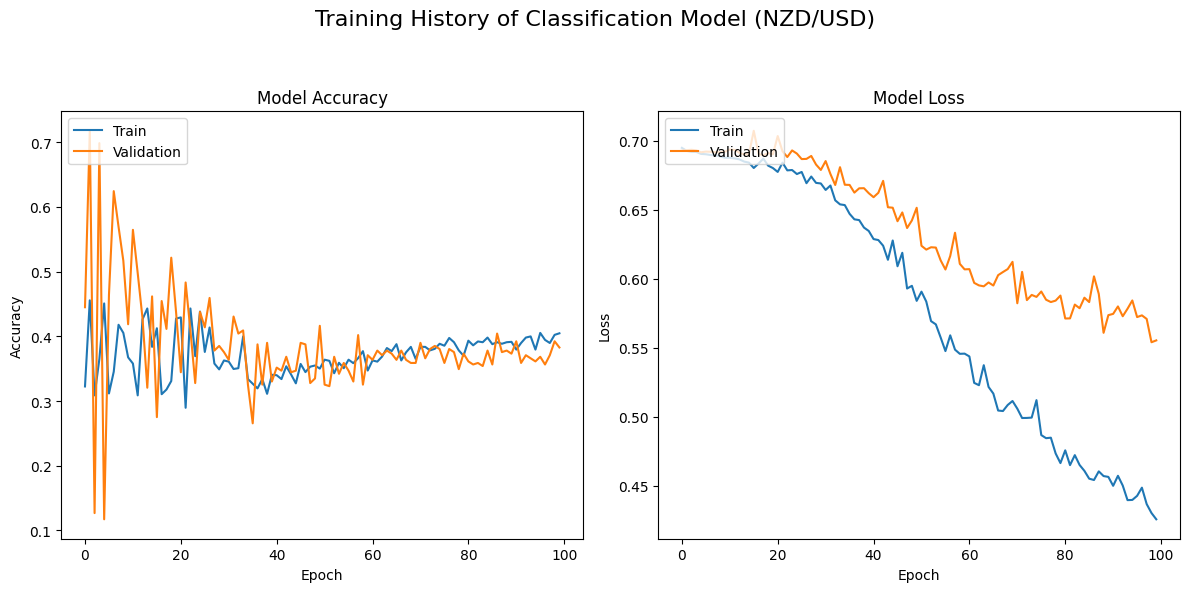

In [35]:
# Visualize training history (Classification Model)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tambahkan title utama
plt.suptitle('Training History of Classification Model (NZD/USD)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # beri ruang untuk suptitle
plt.show()


Grafik overfitting, namun yang digunakan adalah dari checkpoint best_model

### Save Model

In [39]:
# Save model
model_cls.save('NZDUSD_model_cls.h5')
# Save scaler
joblib.dump(scaler, 'NZDUSD_scaler.save')

['NZDUSD_scaler.save']

## Regresi

### Split Data

In [26]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
    )


### Build Model

In [27]:
# Arsitektur model LSTM untuk regresi 5 output
model_reg = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output untuk Close_t+1 hingga Close_t+5
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_reg.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,749 (92.77 KB)

 Trainable params: 23,749 (92.77 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [28]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_reg = ModelCheckpoint('best_model_reg.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_reg = model_reg.fit(
    X_train_reg, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_reg],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1725 - mae: 0.3300
Epoch 1: val_loss improved from inf to 0.00189, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1706 - mae: 0.3273 - val_loss: 0.0019 - val_mae: 0.0328
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0089 - mae: 0.0751
Epoch 2: val_loss improved from 0.00189 to 0.00136, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0089 - mae: 0.0750 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062 - mae: 0.0620
Epoch 3: val_loss did not improve from 0.00136
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0062 - mae: 0.0620 - val_loss: 0.0018 - val_mae: 0.0366
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - mae: 0.0538
Epoch 4: val_loss improved from 0.00136 to 0.00045, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0046 - mae: 0.0537 - val_loss: 4.5190e-04 - val_mae: 0.0167
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037 - mae: 0.0479
Epoch 5: val_loss improved from 0.00045 to 0.00033, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0037 - mae: 0.0478 - val_loss: 3.3012e-04 - val_mae: 0.0144
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031 - mae: 0.0447
Epoch 6: val_loss did not improve from 0.00033
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0031 - mae: 0.0447 - val_loss: 0.0016 - val_mae: 0.0375
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026 - mae: 0.0405
Epoch 7: val_loss did not improve from 0.00033
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0026 - mae: 0.0404 - val_loss: 5.6213e-04 - val_mae: 0.0203
Epoch 8/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021 - mae: 0.0364
Epoch 8: val_loss improved from 0.00033 to 0.00018, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0021 - mae: 0.0364 - val_loss: 1.8345e-04 - val_mae: 0.0109
Epoch 9/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0019 - mae: 0.0348
Epoch 9: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - mae: 0.0348 - val_loss: 5.6737e-04 - val_mae: 0.0212
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0016 - mae: 0.0317
Epoch 10: val_loss improved from 0.00018 to 0.00015, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0016 - mae: 0.0317 - val_loss: 1.4543e-04 - val_mae: 0.0098
Epoch 11/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014 - mae: 0.0292
Epoch 11: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 1.9438e-04 - val_mae: 0.0113
Epoch 12/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0013 - mae: 0.0280
Epoch 12: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 1.5910e-04 - val_mae: 0.0103
Epoch 13/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.9321e-04 - mae: 0.0250
Epoch 13: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.9465e-04 - mae: 0.0251 - val_loss: 3.1013e-04 - val_mae: 0.0153
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.6318e-04 - mae: 0.0246
Epoch 14: val_loss improved from 0.00015 to 0.00011, saving model to best_mo

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 9.6290e-04 - mae: 0.0246 - val_loss: 1.0903e-04 - val_mae: 0.0081
Epoch 15/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.7606e-04 - mae: 0.0234
Epoch 15: val_loss did not improve from 0.00011
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.7333e-04 - mae: 0.0234 - val_loss: 2.4374e-04 - val_mae: 0.0133
Epoch 16/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.2024e-04 - mae: 0.0226
Epoch 16: val_loss did not improve from 0.00011
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.1890e-04 - mae: 0.0226 - val_loss: 1.2800e-04 - val_mae: 0.0090
Epoch 17/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.5867e-04 - mae: 0.0203
Epoch 17: val_loss improved from 0.00011 to 0.00010, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.5924e-04 - mae: 0.0203 - val_loss: 9.9639e-05 - val_mae: 0.0078
Epoch 18/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2055e-04 - mae: 0.0198
Epoch 18: val_loss improved from 0.00010 to 0.00010, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.2007e-04 - mae: 0.0198 - val_loss: 9.8371e-05 - val_mae: 0.0078
Epoch 19/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.3187e-04 - mae: 0.0183
Epoch 19: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.3034e-04 - mae: 0.0183 - val_loss: 9.9471e-05 - val_mae: 0.0079
Epoch 20/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.5197e-04 - mae: 0.0170
Epoch 20: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.5128e-04 - mae: 0.0170 - val_loss: 1.0014e-04 - val_mae: 0.0078
Epoch 21/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.6259e-04 - mae: 0.0172
Epoch 21: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.6173e-04 - mae: 0.0171 - val_loss: 1.3562e-04 - val_mae: 0.0095
Epoch 22/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.7491e-04 - mae: 0.0152
Epoch 22: val_loss improved from 0.00010 to 0.00010, sav

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.7455e-04 - mae: 0.0152 - val_loss: 9.5638e-05 - val_mae: 0.0076
Epoch 23/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.2154e-04 - mae: 0.0141
Epoch 23: val_loss did not improve from 0.00010
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.2134e-04 - mae: 0.0141 - val_loss: 1.0170e-04 - val_mae: 0.0078
Epoch 24/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8741e-04 - mae: 0.0133
Epoch 24: val_loss improved from 0.00010 to 0.00009, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.8708e-04 - mae: 0.0133 - val_loss: 9.3255e-05 - val_mae: 0.0075
Epoch 25/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.7741e-04 - mae: 0.0131
Epoch 25: val_loss improved from 0.00009 to 0.00009, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.7656e-04 - mae: 0.0131 - val_loss: 8.7887e-05 - val_mae: 0.0074
Epoch 26/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.2550e-04 - mae: 0.0116
Epoch 26: val_loss improved from 0.00009 to 0.00009, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2574e-04 - mae: 0.0116 - val_loss: 8.5231e-05 - val_mae: 0.0073
Epoch 27/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.0092e-04 - mae: 0.0112
Epoch 27: val_loss did not improve from 0.00009
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.0122e-04 - mae: 0.0113 - val_loss: 9.0406e-05 - val_mae: 0.0074
Epoch 28/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8308e-04 - mae: 0.0107
Epoch 28: val_loss did not improve from 0.00009
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.8326e-04 - mae: 0.0107 - val_loss: 9.1231e-05 - val_mae: 0.0075
Epoch 29/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7931e-04 - mae: 0.0106
Epoch 29: val_loss improved from 0.00009 to 0.00008, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.7941e-04 - mae: 0.0106 - val_loss: 8.3040e-05 - val_mae: 0.0072
Epoch 30/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.7312e-04 - mae: 0.0103
Epoch 30: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.7310e-04 - mae: 0.0103 - val_loss: 8.7157e-05 - val_mae: 0.0074
Epoch 31/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4885e-04 - mae: 0.0097
Epoch 31: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.4940e-04 - mae: 0.0097 - val_loss: 9.6489e-05 - val_mae: 0.0076
Epoch 32/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.5846e-04 - mae: 0.0098
Epoch 32: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.5812e-04 - mae: 0.0098 - val_loss: 8.4006e-05 - val_mae: 0.0071
Epoch 33/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.4337e-04 - mae: 0.0095
Epoch 33: val_loss did not improve from 0.00008
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.2438e-05 - mae: 0.0074 - val_loss: 8.1865e-05 - val_mae: 0.0072
Epoch 66/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0916e-04 - mae: 0.0082
Epoch 66: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.0855e-04 - mae: 0.0082 - val_loss: 8.6212e-05 - val_mae: 0.0072
Epoch 67/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0074e-04 - mae: 0.0079
Epoch 67: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0070e-04 - mae: 0.0079 - val_loss: 8.8855e-05 - val_mae: 0.0074
Epoch 68/100
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.1794e-05 - mae: 0.0075
Epoch 68: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.1962e-05 - mae: 0.0075 - val_loss: 1.0769e-04 - val_mae: 0.0086
Epoch 69/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2446e-04 - mae: 0.0089
Epoch 69: val_loss did not improve from 0.00008
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0055e-04 - mae: 0.0079 - val_loss: 7.9690e-05 - val_mae: 0.0070
Epoch 86/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.2867e-05 - mae: 0.0076
Epoch 86: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.2849e-05 - mae: 0.0075 - val_loss: 1.1077e-04 - val_mae: 0.0082
Epoch 87/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.3056e-05 - mae: 0.0076
Epoch 87: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 9.3110e-05 - mae: 0.0076 - val_loss: 8.8978e-05 - val_mae: 0.0074
Epoch 88/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.4692e-05 - mae: 0.0076
Epoch 88: val_loss did not improve from 0.00008
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 9.4629e-05 - mae: 0.0076 - val_loss: 1.1751e-04 - val_mae: 0.0086
Epoch 89/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.6791e-05 - mae: 0.0072
Epoch 89: val_loss did not improve from 0.00008
53/53 ━━

### Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1266e-04 - mae: 0.0087
Test Loss (MSE): 0.000113, Test MAE: 0.008732
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


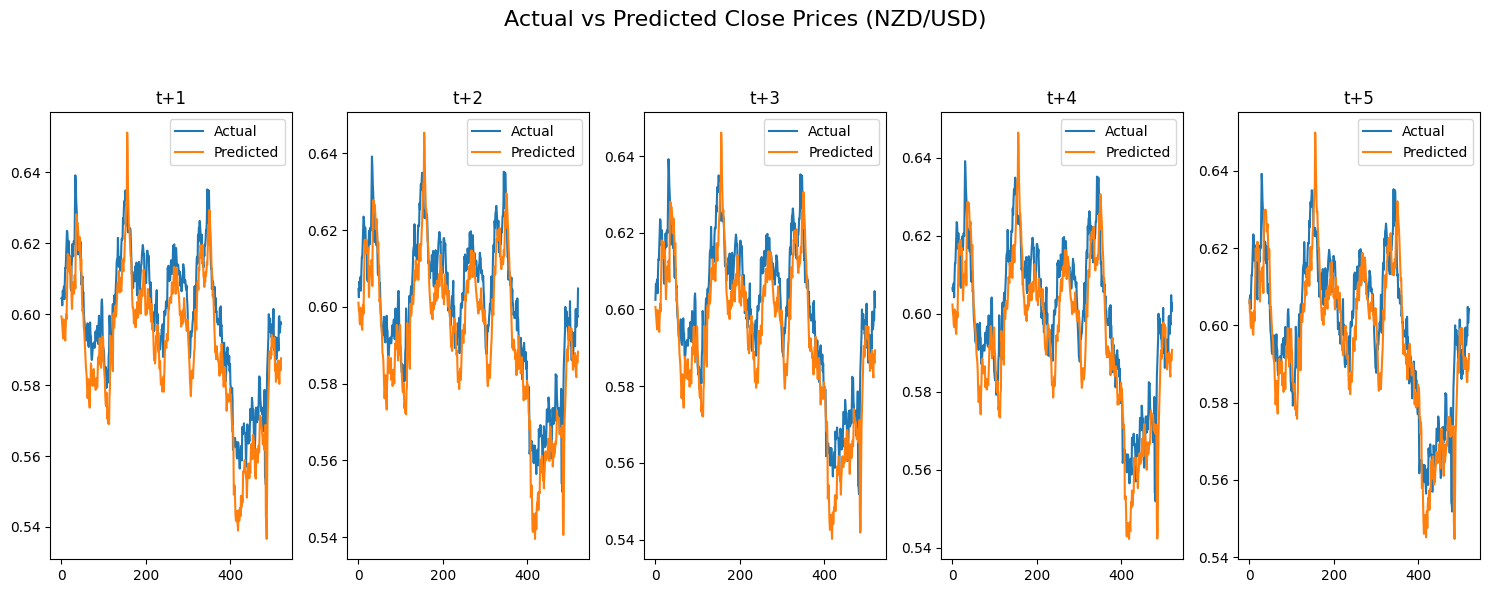

In [33]:
# Evaluasi
loss, mae = model_reg.evaluate(X_test_reg, y_test_reg)
print(f"Test Loss (MSE): {loss:.6f}, Test MAE: {mae:.6f}")

# Plot prediksi vs aktual
y_pred_reg = model_reg.predict(X_test_reg)

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(y_test_reg[:, i], label='Actual')
    plt.plot(y_pred_reg[:, i], label='Predicted')
    plt.title(f"t+{i+1}")  # judul untuk masing-masing subplot
    plt.legend()

plt.suptitle("Actual vs Predicted Close Prices (NZD/USD)", fontsize=16)  # satu judul utama
plt.tight_layout(rect=[0, 0, 1, 0.93])  # agar tidak menabrak suptitle
plt.show()


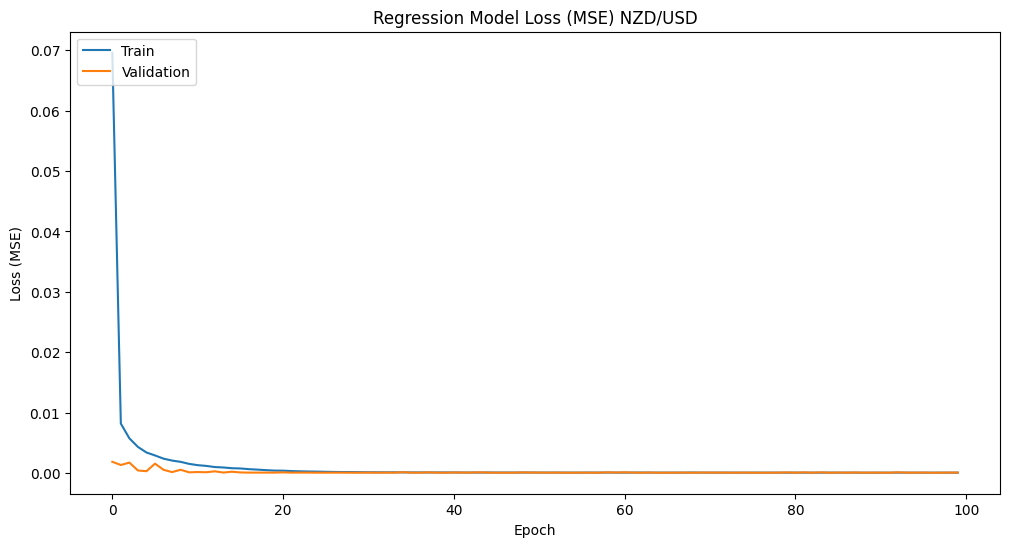

In [34]:
# Visualize training history (Regression Model)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values for regression
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Regression Model Loss (MSE) NZD/USD')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save Model

In [36]:
# Save model regresi
model_reg.save('NZDUSD_model_reg.h5')

# Inferensi

In [38]:
# Ambil window terakhir dari array features yang sudah disiapkan sebelumnya
latest_sequence = features[-window_size:]  # Shape (90, features)

# Ubah ke bentuk batch
X_latest = np.expand_dims(latest_sequence, axis=0).astype(np.float32)

# Get the last actual close price BEFORE scaling
last_actual_close = data['Close'].iloc[-window_size - 1] # Get the close price from the row *before* the latest sequence starts

# Prediksi probabilitas naik (tetap menggunakan model_cls)
y_pred_probs_cls = model_cls.predict(X_latest)
y_pred_cls = (y_pred_probs_cls > 0.5).astype(int)

# Prediksi harga penutupan (scaled, tetap menggunakan model_reg)
y_pred_price_scaled = model_reg.predict(X_latest)

# Kembalikan skala harga ke bentuk aslinya
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Function to inverse transform manual only for the Close column
def inverse_minmax(value, vmin, vmax):
    return value * (vmax - vmin) + vmin - 0.081

predicted_actual_prices = []
results = []
reference_price = last_actual_close # Start with the last actual close as the reference for t+1

print("📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):")
print("📈 Prediksi Harga Penutupan (Close) Pekan Depan:")

for i in range(5):
    # Inverse transform the predicted scaled price for the current day (t+i+1)
    predicted_scaled_price = y_pred_price_scaled[0, i]
    predicted_original_price_absolute = inverse_minmax(predicted_scaled_price, close_min, close_max)

    # Determine classification relative to the reference price (previous day's close or predicted close)
    classification = "Naik" if predicted_original_price_absolute > reference_price else "Turun"

    print(f"t+{i+1}: {classification} (Probabilitas: {y_pred_probs_cls[0, i]:.2f}), Prediksi Harga: {predicted_original_price_absolute:.5f}")

    result = {
        f"t+{i+1}": {
            "classification": classification,
            "classification_probability": float(y_pred_probs_cls[0, i]),
            "predicted_close_price": float(predicted_original_price_absolute)
        }
    }
    results.append(result)

    # Update the reference price for the next iteration
    reference_price = predicted_original_price_absolute


# Menyimpan hasil ke file JSON
output_filename = "NZDUSD_prediksi.json"
with open(output_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nHasil prediksi klasifikasi dan harga telah disimpan ke {output_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):
📈 Prediksi Harga Penutupan (Close) Pekan Depan:
t+1: Naik (Probabilitas: 0.63), Prediksi Harga: 0.60309
t+2: Naik (Probabilitas: 0.67), Prediksi Harga: 0.60327
t+3: Naik (Probabilitas: 0.78), Prediksi Harga: 0.60353
t+4: Naik (Probabilitas: 0.89), Prediksi Harga: 0.60368
t+5: Naik (Probabilitas: 0.96), Prediksi Harga: 0.60422

Hasil prediksi klasifikasi dan harga telah disimpan ke NZDUSD_prediksi.json
